In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM

2024-01-11 18:15:21.952381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = 'data/crypto/BTCUSDT.csv'
df = pd.read_csv(path)
df

,timestamp_utc,timestamp,open,high,low,close,volume,turnover
0,2020-03-25 10:30:08.128000+00:00,1585132200000,6500.0,6500.0,6500.0,6500.0,0.002,1.300000e+01
1,2020-03-25 10:45:25.632000+00:00,1585133100000,6500.0,6591.5,6500.0,6591.5,0.002,1.318300e+01
2,2020-03-25 11:00:43.136000+00:00,1585134000000,6591.5,6622.5,6585.5,6590.5,37.803,2.491407e+05
3,2020-03-25 11:16:00.640000+00:00,1585134900000,6590.5,6628.5,6588.5,6618.0,141.338,9.353749e+05
4,2020-03-25 11:29:07.072000+00:00,1585135800000,6618.0,6618.0,6457.5,6499.5,120.703,7.845091e+05
...,...,...,...,...,...,...,...,...
132798,2024-01-07 17:59:02.400000+00:00,1704650400000,44070.9,44150.0,44037.9,44118.0,519.299,2.290517e+07
132799,2024-01-07 18:14:19.904000+00:00,1704651300000,44118.0,44173.3,44100.0,44113.8,326.239,1.439852e+07
132800,2024-01-07 18:29:37.408000+00:00,1704652200000,44113.8,44184.9,44108.8,44158.3,366.902,1.620259e+07
132801,2024-01-07 18:44:54.912000+00:00,1704653100000,44158.3,44189.9,44093.5,44106.5,602.564,2.659858e+07


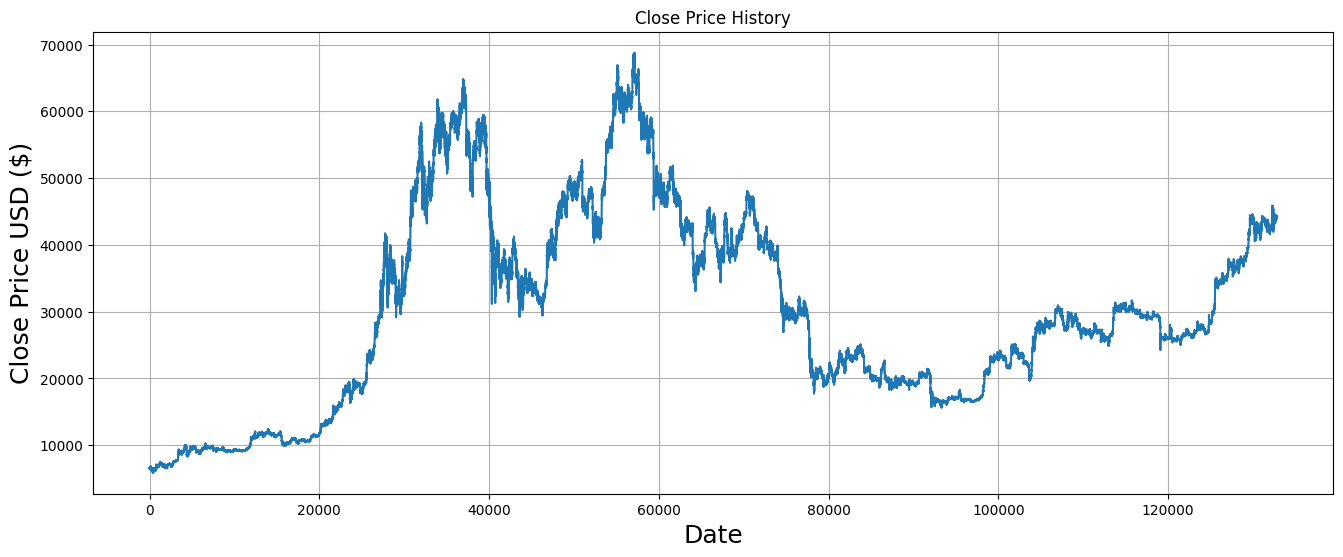

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.grid(True)
plt.show()

In [5]:
data = df.filter(['close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .80))

training_data_len

106243

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00996749],
       [0.01142208],
       [0.01140618],
       ...,
       [0.60862577],
       [0.6078023 ],
       [0.60747323]])

In [12]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

106183/106183 [==============================] - 2225s 21ms/step - loss: 7.5407e-05


In [14]:
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mse = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_absolute_error(y_test, predictions))

print('MSE:', mse)
print('RMSE:', rmse)

830/830 [==============================] - 13s 14ms/step
MSE: 58.580628662109376
RMSE: 7.6537983160068555


/var/folders/_c/npprpzfn2fsgjjxzkzbrynlm0000gn/T/ipykernel_7136/2007145741.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


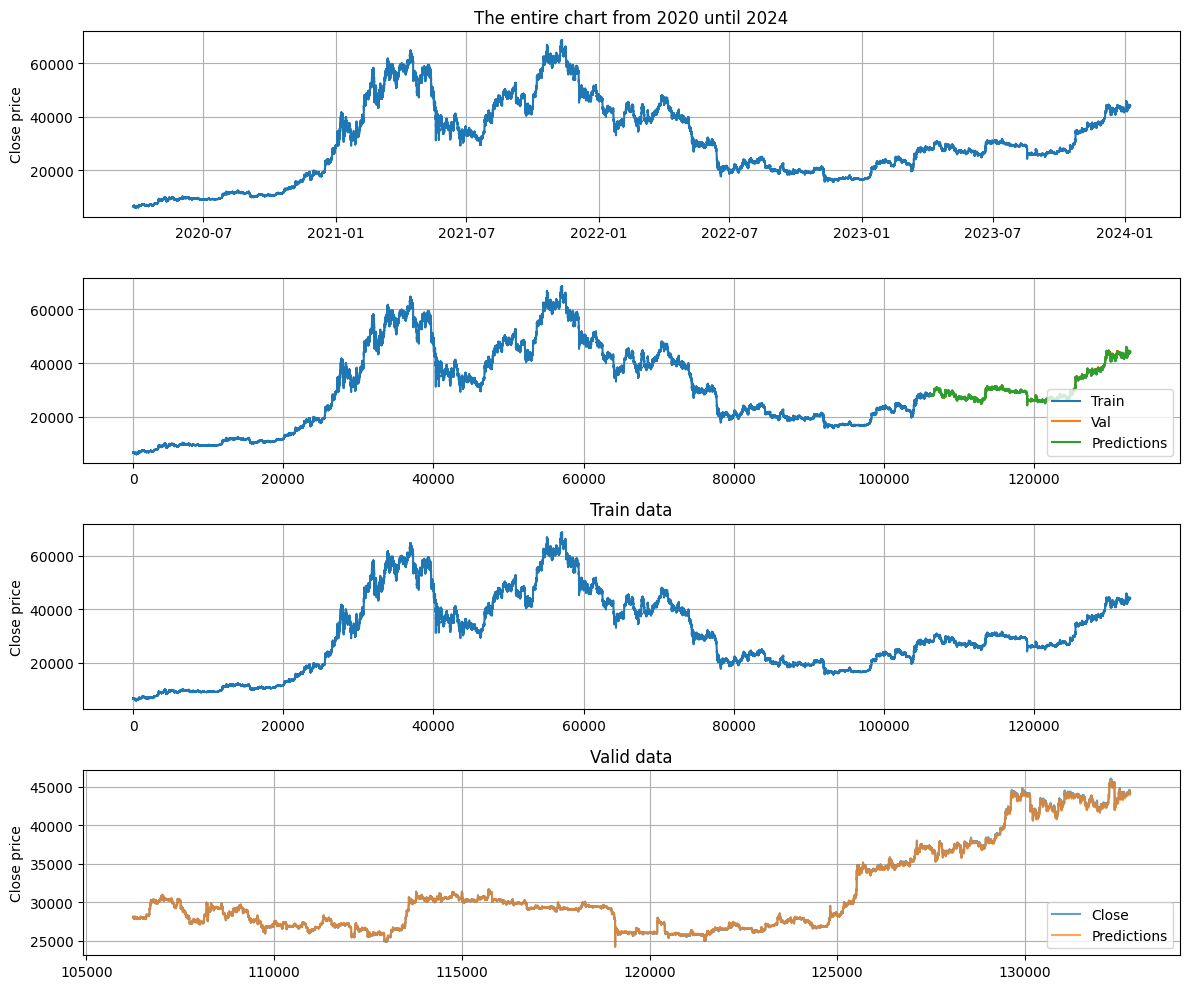

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))
axes = axes.flatten()

y = df['close']
x = [dt.datetime.fromtimestamp(timestamp) for timestamp in (df['timestamp'] / 1000)]

axes[0].plot(x, y)
axes[0].grid(True)
axes[0].set_ylabel('Close price')
axes[0].set_xlabel(None)
axes[0].set_title('The entire chart from 2020 until 2024')

train = data[:training_data_len]
train_y = data['close']
# train_x = [dt.datetime.fromtimestamp(timestamp) for timestamp in (data['timestamp'] / 1000)]

valid = data[training_data_len:]
valid['predictions'] = predictions
valid_y = valid[['predictions', 'close']]
# valid_x = [dt.datetime.fromtimestamp(timestamp) for timestamp in (data['timestamp'] / 1000)]

axes[1].plot(train_y)
axes[1].plot(valid_y)
axes[1].grid(True)
axes[1].legend(['Train', 'Val', 'Predictions'], loc='lower right')
axes[2].set_ylabel('Close price')
axes[2].set_xlabel(None)
axes[2].set_title('Prediction data')

axes[2].plot(train_y)
axes[2].grid(True)
axes[2].set_ylabel('Close price')
axes[2].set_xlabel(None)
axes[2].set_title('Train data')

axes[3].plot(valid_y, alpha=0.7)
axes[3].grid(True)
axes[3].legend(['Close', 'Predictions'], loc='lower right')
axes[3].set_ylabel('Close price')
axes[3].set_xlabel(None)
axes[3].set_title('Valid data')

plt.tight_layout()
plt.show()